In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import logging # 使用 logging 模組記錄資訊

In [2]:
%matplotlib inline

In [ ]:
# --- 從你的 predictor.py 匯入類別 ---
try:
    from predictor import FakeProfilePredictor
except ImportError:
    logging.error("錯誤：無法從 predictor.py 匯入 FakeProfilePredictor。")
    logging.error("請確保 predictor.py 檔案存在於正確的位置。")
    exit() # 嚴重錯誤，無法繼續

# --- 設定 Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def load_data(filepath: str) -> pd.DataFrame:
    """載入 CSV 數據並進行基本檢查"""
    logging.info(f"正在從 {filepath} 載入資料...")
    try:
        df = pd.read_csv(filepath)
        logging.info(f"成功載入 {len(df)} 筆資料。")
        # 檢查df是否為空
        if df.empty:
            logging.warning(f"載入的檔案 {filepath} 是空的。")
        return df
    except FileNotFoundError:
        logging.error(f"錯誤：找不到檔案 {filepath}。")
        raise # 將錯誤向上拋出，讓主程式處理
    except Exception as e:
        logging.error(f"載入 CSV '{filepath}' 時發生錯誤：{e}")
        raise

def perform_predictions(predictor: FakeProfilePredictor, df: pd.DataFrame) -> pd.Series:
    """使用 predictor 對 DataFrame 進行批次預測"""
    logging.info("開始進行批次預測...")
    start_time = time.time()

    # 確保輸入 DataFrame 包含所有必要的特徵
    # predictor 內部現在會做這個檢查，但也可以在這裡做初步檢查
    required_cols = set(predictor.required_features)
    if not required_cols.issubset(df.columns):
        missing = required_cols - set(df.columns)
        logging.error(f"輸入 DataFrame 缺少預測所需的欄位: {missing}")
        raise ValueError(f"輸入 DataFrame 缺少預測所需的欄位: {missing}")

    try:
        # 直接將整個 DataFrame 傳遞給 predict 方法進行批次預測
        predictions = predictor.predict(df) # 假設 predict 返回 List[int]
        num_predictions = len(predictions)

        end_time = time.time()
        prediction_time = end_time - start_time
        logging.info(f"批次預測完成！共 {num_predictions} 筆。")
        logging.info(f"總耗時：{prediction_time:.2f} 秒。")
        if num_predictions > 0:
            logging.info(f"平均每筆資料預測耗時：{prediction_time / num_predictions * 1000:.4f} 毫秒。")

        return pd.Series(predictions, index=df.index) # 將列表轉為 Series，索引對齊

    except (ValueError, TypeError) as e:
        logging.error(f"預測過程中發生錯誤（可能是數據問題或類型不匹配）: {e}")
        raise # 將錯誤向上拋出
    except Exception as e:
        logging.error(f"預測過程中發生未預期的錯誤: {e}")
        raise

def evaluate_performance(y_true: pd.Series, y_pred: pd.Series, labels=None):
    """計算並顯示模型性能指標"""
    logging.info("--- 模型表現評估 ---")

    if y_true.isnull().any() or y_pred.isnull().any():
        logging.warning("真實標籤或預測結果中存在 NaN 值，無法進行準確評估。請檢查數據。")
        # 若有 NaN，移除NaN再評估
        valid_indices = y_true.notna() & y_pred.notna()
        if not valid_indices.any():
            logging.error("沒有有效的標籤/預測對可供評估。")
            return None # 無法評估
        logging.warning(f"將僅使用 {valid_indices.sum()} 筆有效的 (非 NaN) 資料進行評估。")
        y_true = y_true[valid_indices]
        y_pred = y_pred[valid_indices]
        if len(y_true) == 0: # 再次檢查
            logging.error("移除 NaN 後，沒有有效的標籤/預測對可供評估。")
            return None

    # 確保類型一致 (例如都轉成 int)
    try:
        y_true = y_true.astype(int)
        y_pred = y_pred.astype(int)
    except ValueError as e:
        logging.error(f"轉換標籤/預測為整數時出錯：{e}。請確保它們是有效的數字表示。")
        return None

    accuracy = accuracy_score(y_true, y_pred)
    # 假設是二元分類，如果有多類別，需要調整 average 參數
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

    logging.info(f"準確率 (Accuracy): {accuracy:.4f}")
    logging.info(f"精確率 (Precision): {precision:.4f}")
    logging.info(f"召回率 (Recall): {recall:.4f}")
    logging.info(f"F1 分數 (F1 Score): {f1:.4f}")

    logging.info("\n分類報告 (Classification Report):")
    try:
        report = classification_report(y_true, y_pred, zero_division=0, target_names=labels)
        print(report) # Classification report 通常格式較寬，直接 print 效果較好
    except ValueError as ve:
        logging.error(f"生成分類報告時出錯：{ve}")
        logging.error("請檢查 y_true 和 y_pred 的值是否一致且有效。")

    return y_true, y_pred # 返回可能經過處理的 y_true, y_pred

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, labels=None):
    """繪製並顯示混淆矩陣"""
    logging.info("正在繪製混淆矩陣...")

    # --- 設定 Matplotlib 支持中文顯示 ---
    try:
        # ** 在這裡添加字體設定 **
        # Windows 環境建議使用 'Microsoft JhengHei' (繁體) 或 'SimHei' (簡體)
        # macOS 環境建議使用 'PingFang TC', 'PingFang SC', 'Heiti TC' 等
        # Linux 環境建議使用 'WenQuanYi Micro Hei', 'Noto Sans CJK TC' 等
        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # <--- 把 'Microsoft JhengHei' 換成你系統有的字體
        plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題 (通常和中文字體一起設定)
        logging.info(f"已嘗試設定字體為 {plt.rcParams['font.sans-serif']} 以支持中文顯示。")
    except Exception as font_ex:
         logging.warning(f"設定中文字體時出錯: {font_ex}")
         logging.warning("如果圖表中的中文顯示為方塊，請確保系統已安裝並 Matplotlib 能找到支援中文的字體。")
    # --- 字體設定結束 ---
    
    cm = confusion_matrix(y_true, y_pred)

    # 獲取實際存在的標籤用於繪圖
    if labels is None:
        plot_labels = sorted(y_true.unique())
    else:
         plot_labels = labels

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=plot_labels, yticklabels=plot_labels)
    plt.xlabel('預測標籤 (Predicted Label)') # <--- 這些中文現在應該能正確顯示
    plt.ylabel('真實標籤 (True Label)')   # <--- 這些中文現在應該能正確顯示
    plt.title('混淆矩陣 (Confusion Matrix)') # <--- 這些中文現在應該能正確顯示
    plt.show()
    logging.info("混淆矩陣繪製完成。")

2025-04-13 01:31:00,460 - INFO - 正在從 ./data/卡提諾_final.csv 載入資料...
2025-04-13 01:31:00,465 - INFO - 成功載入 47 筆資料。
2025-04-13 01:31:00,465 - INFO - 正在初始化預測器...
2025-04-13 01:31:00,489 - INFO - 預測器初始化成功。
2025-04-13 01:31:00,490 - INFO - 開始進行批次預測...
2025-04-13 01:31:00,497 - INFO - 批次預測完成！共 47 筆。
2025-04-13 01:31:00,498 - INFO - 總耗時：0.01 秒。
2025-04-13 01:31:00,499 - INFO - 平均每筆資料預測耗時：0.1439 毫秒。
2025-04-13 01:31:00,500 - INFO - 正在將預測結果儲存到 ./data/卡提諾_final_with_predictions.csv...
2025-04-13 01:31:00,503 - INFO - 儲存成功。
2025-04-13 01:31:00,503 - INFO - --- 模型表現評估 ---
2025-04-13 01:31:00,513 - INFO - 準確率 (Accuracy): 0.7234
2025-04-13 01:31:00,514 - INFO - 精確率 (Precision): 0.6486
2025-04-13 01:31:00,514 - INFO - 召回率 (Recall): 1.0000
2025-04-13 01:31:00,515 - INFO - F1 分數 (F1 Score): 0.7869
2025-04-13 01:31:00,516 - INFO - 
分類報告 (Classification Report):
2025-04-13 01:31:00,522 - INFO - 正在繪製混淆矩陣...
2025-04-13 01:31:00,522 - INFO - 已嘗試設定字體為 ['Microsoft JhengHei'] 以支持中文顯示。


              precision    recall  f1-score   support

         假帳號       1.00      0.43      0.61        23
        真實帳號       0.65      1.00      0.79        24

    accuracy                           0.72        47
   macro avg       0.82      0.72      0.70        47
weighted avg       0.82      0.72      0.70        47



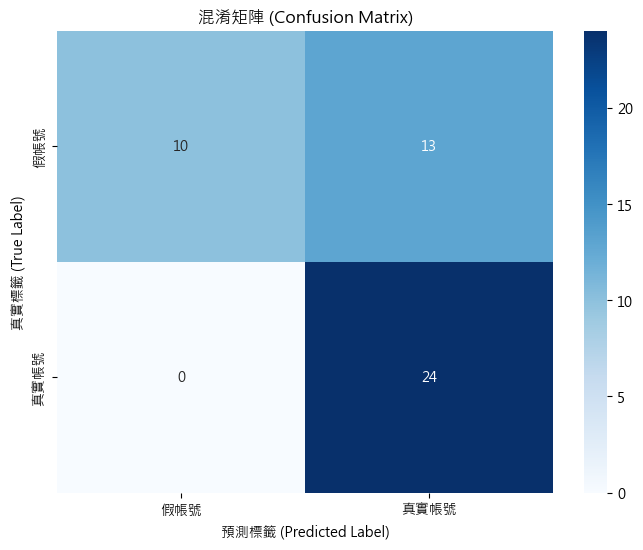

2025-04-13 01:31:00,658 - INFO - 混淆矩陣繪製完成。


In [9]:
# --- 設定區塊 ---
INPUT_CSV_PATH = './data/卡提諾_final.csv'             # 包含真實標籤的輸入資料路徑
OUTPUT_CSV_PATH = './data/卡提諾_final_with_predictions.csv' # 儲存預測結果的檔案路徑
TRUE_LABEL_COLUMN = 'class'                        # <--- 重要：改成你資料中真實標籤的欄位名稱
PREDICTED_COLUMN = 'predicted_outcome'               # 新增的預測結果欄位名稱

# 如果你的模型/scaler 不在 predictor.py 預設的路徑，可以在這裡指定
# MODEL_PATH = 'path/to/your/model.pkl'
# SCALER_PATH = 'path/to/your/scaler.pkl'

try:
    # 1. 載入數據
    df = load_data(INPUT_CSV_PATH)
    if df.empty:
        logging.info("數據為空，終止執行。")
        exit()
    
    # 2. 初始化預測器
    logging.info("正在初始化預測器...")
    predictor = FakeProfilePredictor()
    logging.info("預測器初始化成功。")

    # 3. 執行預測
    df[PREDICTED_COLUMN] = perform_predictions(predictor, df)

    # 4. (可選) 儲存帶有預測的結果
    logging.info(f"正在將預測結果儲存到 {OUTPUT_CSV_PATH}...")
    try:
        df.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8-sig')
        logging.info("儲存成功。")
    except Exception as e:
        logging.warning(f"儲存結果到 CSV 時發生錯誤：{e}") # 非致命錯誤，繼續評估

    # 5. 評估模型表現
    if TRUE_LABEL_COLUMN not in df.columns:
        logging.warning(f"在資料中找不到真實標籤欄位 '{TRUE_LABEL_COLUMN}'。")
        logging.warning("將無法計算模型表現指標和繪製混淆矩陣。")
    else:
        y_true = df[TRUE_LABEL_COLUMN]
        y_pred = df[PREDICTED_COLUMN]

        # 定義標籤名稱，順序對應 [0, 1]
        custom_labels = ['假帳號', '真實帳號']

        # 執行評估並獲取可能被清洗過的標籤
        eval_result = evaluate_performance(y_true, y_pred, labels=custom_labels) # <-- 假設 0=假, 1=真, 修改標籤

        if eval_result:
            y_true_clean, y_pred_clean = eval_result
            # 6. 繪製混淆矩陣 (使用可能被清洗過的標籤)
            plot_confusion_matrix(y_true_clean, y_pred_clean, labels=custom_labels) # <-- 假設 0=假, 1=真

except (FileNotFoundError, ValueError, TypeError, ImportError) as e:
    # 捕捉預期的、我們自己引發的或導入時的錯誤
    logging.error(f"腳本執行失敗：{e}")

except Exception as e:
    # 捕捉所有其他未預期的錯誤
    logging.exception(f"發生未預期的嚴重錯誤，腳本終止。") # logging.exception 會包含 traceback